# Posterior Sampling в задаче RL


## Библиотеки


In [275]:

from abc import abstractmethod

import numpy as np
import pandas as pd
from scipy.stats import gennorm

import matplotlib.pyplot as plt


## Среда

In [276]:
class RiverSwim:
    def __init__(self,
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000,
                 rr   = 1.0,
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr

    @property
    def action_count(self):
        return 2

    @property
    def states_count(self):
        return 2 + self._interm_states

    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]

        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr

        self._steps += 1
        return self._current_state, reward, False


## Агент


In [277]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_name(self):
        return type(self).__name__

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        return self._q_matrix

    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


In [278]:
class PosteriorSamplingAgent:
    def __init__(self, n, K, gamma=0.95):
        self._gamma = gamma
        self._nu = 0
        self._T = np.ones((n, n, K)) # state_i -> state_j by action
        self._S = np.ones((n, n, K))
        self._V = np.ones(n)
        self._mu = np.ones((n, K))
        self._alpha = np.ones((n, K))
        self._beta = np.ones((n, K))
        self._R = np.ones((n, K))

    def get_name(self):
        return type(self).__name__

    def get_action(self, state):

        return np.argmax((self._R + np.tensordot(self._V, self._S, axes=([0], [1])))[state])

    def get_q_matrix(self):
        return np.sum(self._S, axis=0)

    def start_episode(self):
        for i in range(self._S.shape[0]):
            for k in range(self._S.shape[2]):
                self._S[i, :, k] = np.random.dirichlet(self._T[i, :, k])

        for i in range(self._R.shape[0]):
            for j in range(self._R.shape[1]):
                self._R[i, j] = gennorm.rvs(self._alpha[i, j], scale=self._beta[i, j], loc=self._mu[i, j])

        self._V = np.max(self._R + np.tensordot(self._V, self._S, axes=([0], [1])), axis=1)

    def update(self, state, action, reward, next_state):
        self._T[state, next_state, action] += 1

        new_alpha = self._alpha[state, action] + 1 / 2
        new_beta = self._beta[state, action] + (1 * self._nu) / (self._nu + 1) * (reward - self._mu[state, action]) ** 2 / 2
        new_mu = (self._nu * self._mu[state, action] + 1 * reward) / (self._nu + 1)

        self._alpha[state, action] = new_alpha
        self._beta[state, action] = new_beta
        self._mu[state, action] = new_mu

        self._nu += 1


## Обучение

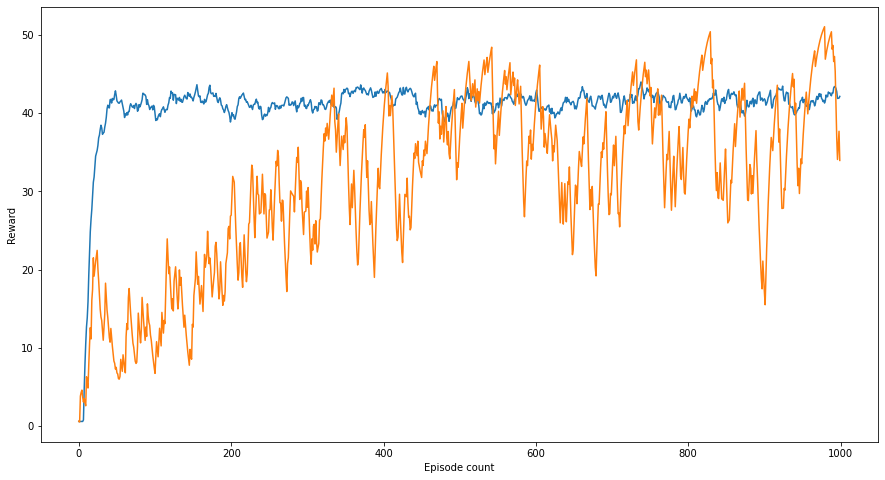

/tmp/ipykernel_360396/1800443573.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


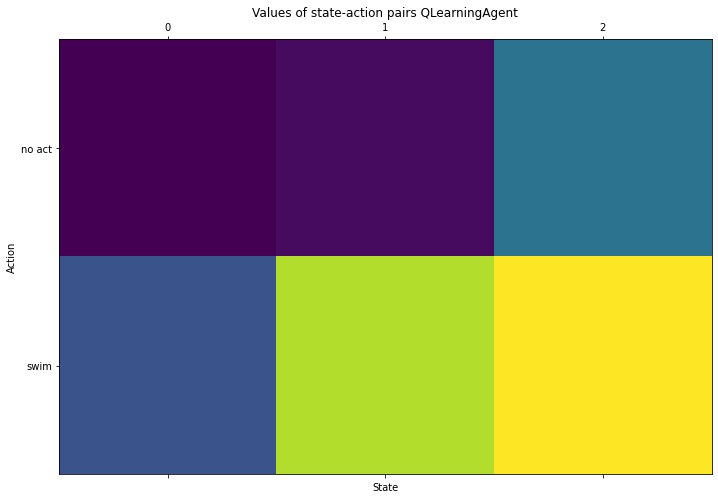

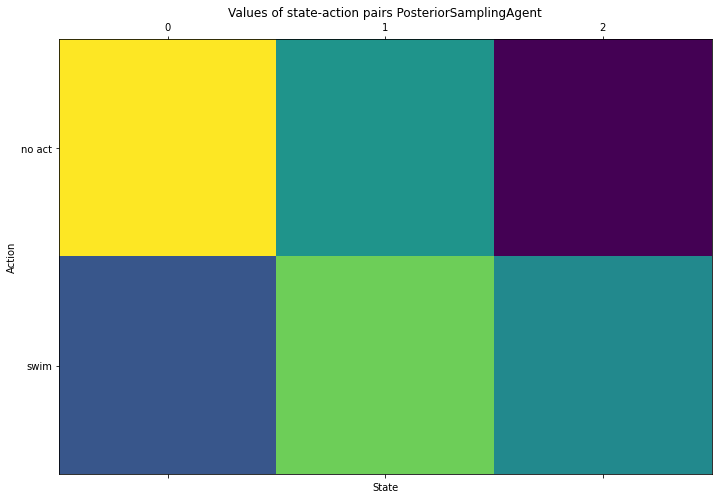

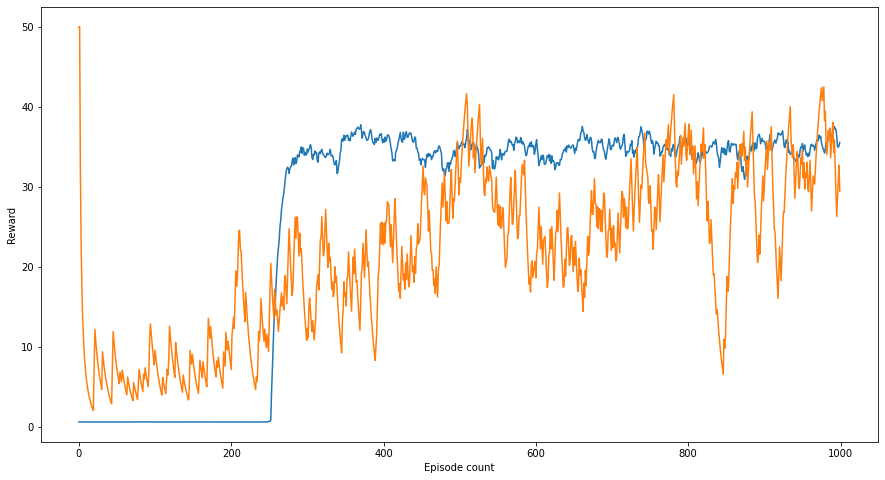

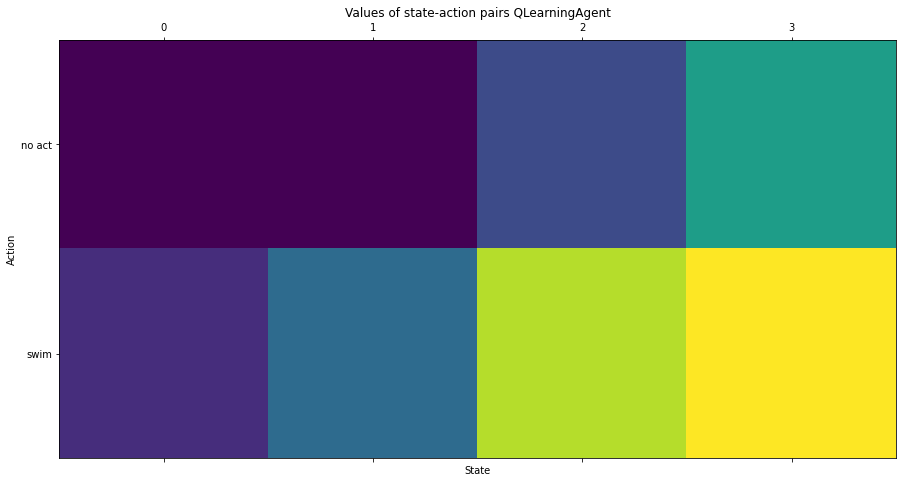

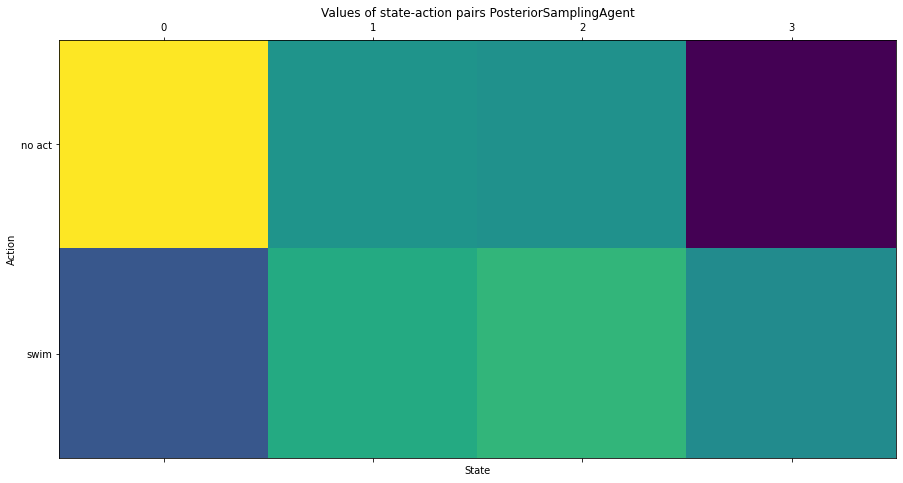

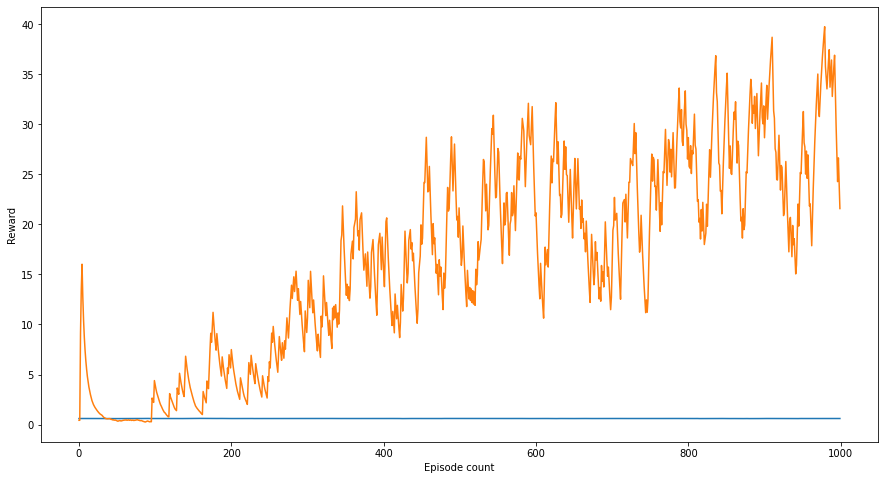

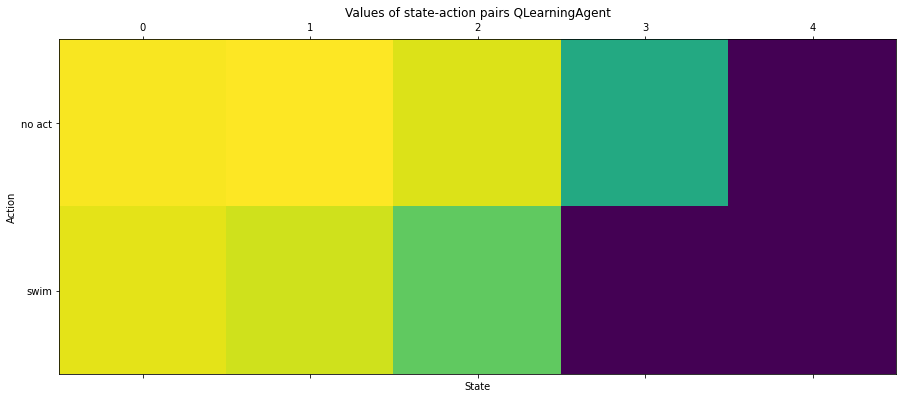

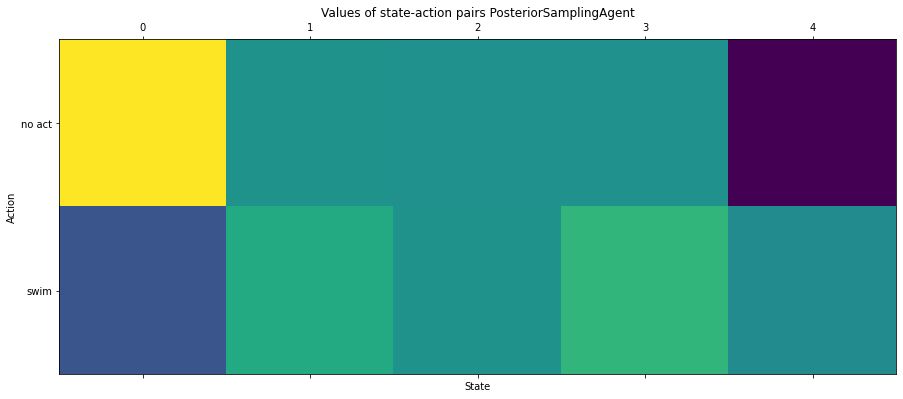

In [279]:
ms = 128
episodes = 1000
actions = 2

states = np.arange(1, 4)

for n in states:
    plt.figure(figsize=(15, 8))

    agents = [
        QLearningAgent(2+n, actions),
        PosteriorSamplingAgent(2+n, actions)
    ]

    for agent in agents:
        episode_rewards = []
        for ep in range(episodes):
            river_swim = RiverSwim(n, ms)

            state, ep_reward, is_done = river_swim._current_state, 0.0, False
            agent.start_episode()
            while not is_done:
                action = agent.get_action(state)
                next_state, reward, is_done = river_swim.step(action)
                agent.update(state, action, reward, next_state)

                state = next_state
                ep_reward += reward

            episode_rewards.append(ep_reward)

        plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean(), label=agent.get_name())

    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()

    for agent in agents:
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111)
        ax.matshow(agent.get_q_matrix().T)
        ax.set_yticklabels(['', 'no act', 'swim'])
        plt.xlabel("State")
        plt.ylabel("Action")
        plt.title("Values of state-action pairs {}".format(agent.get_name()))
        plt.show()


## Выводы

PosteriorSampling в отличии от QLearning справляется с большим числом состояний. Его полученная стратегия больше отображает реальность. Если мы вдруг добрались до крайнего состояния, то нам всегда выгоднее оставаться в этом положении. В QLearning до крайнего положения не добираемся. 